Name: Shahed Razavi   Student ID: 99104627

1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os

from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

###PART 1:

In [3]:
# def noise(input,factor=0.3):
# 	output = input + factor * torch.randn_like(input) 
# 	output = torch.clip(output,0.,1.)
# 	return output


class Noise(object):
    def __init__(self, factor=0.3):
      self.factor = factor

    def __call__(self, x):
      out = x + self.factor * torch.randn_like(x)
      out = torch.clip(out,0.,1.)
      return out

In [4]:
main_dir = 'dataset'

train_MNIST = torchvision.datasets.MNIST(main_dir, train=True, download=True)
test_MNIST = torchvision.datasets.MNIST(main_dir, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
train_data , val_data = random_split(train_MNIST, [int(0.8*len(train_MNIST)),int(0.2*len(train_MNIST))])

transform = transforms.Compose([
    transforms.ToTensor(),
    Noise()
])
transform2 = transforms.Compose([
    transforms.ToTensor()
])
batch_size=140


train_data_noised = [[transform2(d[0]) , transform(d[0]), d[1]] for d in train_data]
val_data_noised = [[transform2(d[0])  , transform(d[0]), d[1]] for d in val_data]
test_data_noised = [[transform2(d[0])  , transform(d[0]), d[1]] for d in test_MNIST]

train_loader = torch.utils.data.DataLoader(train_data_noised, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data_noised, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_noised, batch_size=batch_size, shuffle=True)

###PART 2:

In [6]:
latent_dim = 4

class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(1,8,3,padding=1,stride=2),
        nn.ReLU(True),
        nn.Conv2d(8,16,3,padding=1,stride=2),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.Conv2d(16,32,3,padding=0,stride=2),
        nn.ReLU(True)
    )

    self.fl = nn.Flatten(start_dim=1)
    self.fc = nn.Sequential(
        nn.Linear(3*3*32, 128),
        nn.ReLU(True),
        nn.Linear(128, latent_dim),
    )

    self.latent_dim = latent_dim
  
  def forward(self, inp):
    out = self.cnn(inp)
    out = self.fl(out)
    out = self.fc(out)
    return out



class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.decode_fc = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(True),
        nn.Linear(128, 3*3*32),
        nn.ReLU(True)
    )

    self.ufl = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

    self.decode_cnn = nn.Sequential(
        nn.ConvTranspose2d(32,16,3,output_padding=0,stride=2),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16,8,3,output_padding=1,padding=1,stride=2),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8,1,3,output_padding=1,padding=1,stride=2)
    )
    

    self.latent_dim = latent_dim
  
  def forward(self, inp):
    out = self.decode_fc(inp)
    out = self.ufl(out)
    out = self.decode_cnn(out)
    return torch.sigmoid(out)

In [7]:
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)


opt_params = [
	{'params': encoder.parameters()},
	{'params': decoder.parameters()}
]
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(opt_params, lr=0.001)
n_epochs = 15
for epoch in range(n_epochs):
  train_loss, val_loss = 0, 0
  encoder.train()
  decoder.train()

  for i, (images, noised_images, labels) in enumerate(train_loader):
    images = images.to(device)
    noised_images = noised_images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    out = encoder(noised_images)
    out = decoder(out)
    l = loss(out, images)

    train_loss += batch_size * l
    l.backward()
    optimizer.step()
  

  encoder.eval()
  decoder.eval()

  with torch.no_grad():
    for i, (images, noised_images, labels) in enumerate(val_loader):
      images = images.to(device)
      noised_images = noised_images.to(device)
      labels = labels.to(device)
      out = encoder(noised_images)
      out = decoder(out)
      l = loss(out, images)
      val_loss += batch_size * l
  

  train_loss /= len(train_loader.dataset)
  val_loss /= len(val_loader.dataset)
  print(f"[Epoch {epoch}]\t"
        f"Train Loss: {train_loss:.3f}\t"
        f"Validation Loss: {val_loss:.3f}")


[Epoch 0]	Train Loss: 0.089	Validation Loss: 0.050
[Epoch 1]	Train Loss: 0.047	Validation Loss: 0.044
[Epoch 2]	Train Loss: 0.042	Validation Loss: 0.041
[Epoch 3]	Train Loss: 0.039	Validation Loss: 0.038
[Epoch 4]	Train Loss: 0.037	Validation Loss: 0.036
[Epoch 5]	Train Loss: 0.035	Validation Loss: 0.034
[Epoch 6]	Train Loss: 0.033	Validation Loss: 0.033
[Epoch 7]	Train Loss: 0.032	Validation Loss: 0.032
[Epoch 8]	Train Loss: 0.031	Validation Loss: 0.031
[Epoch 9]	Train Loss: 0.030	Validation Loss: 0.030
[Epoch 10]	Train Loss: 0.030	Validation Loss: 0.030
[Epoch 11]	Train Loss: 0.029	Validation Loss: 0.029
[Epoch 12]	Train Loss: 0.028	Validation Loss: 0.029
[Epoch 13]	Train Loss: 0.028	Validation Loss: 0.029
[Epoch 14]	Train Loss: 0.028	Validation Loss: 0.028


###PART 3:

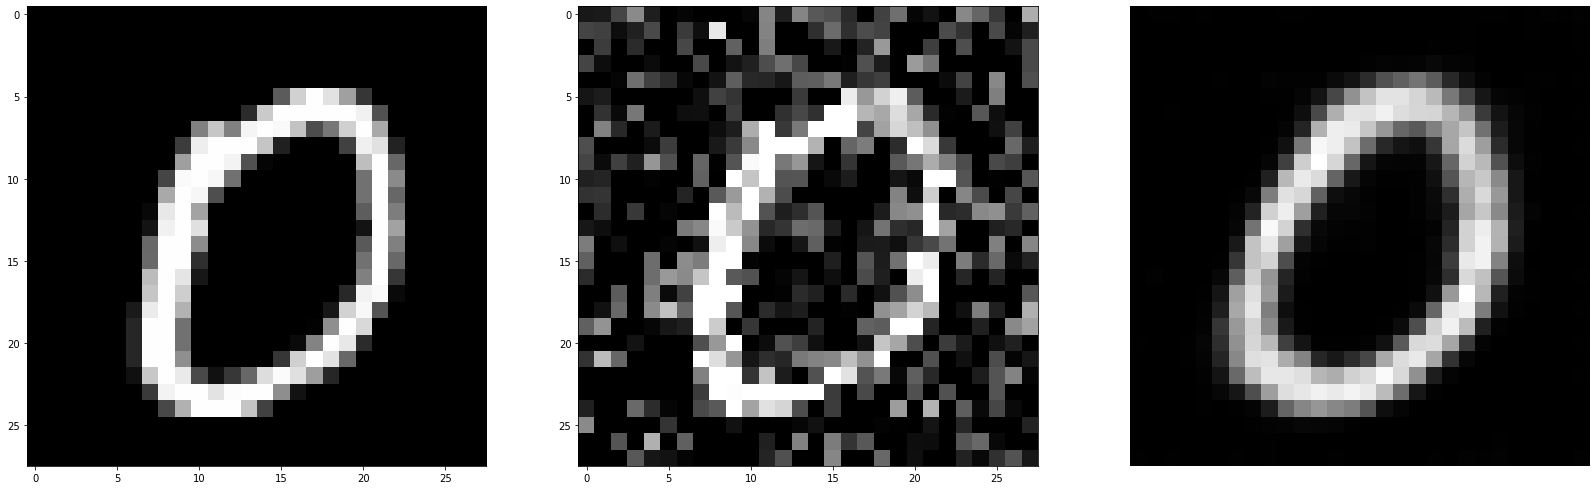

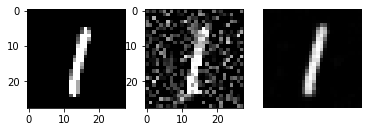

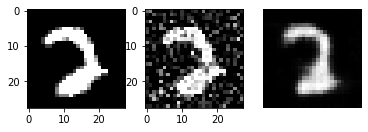

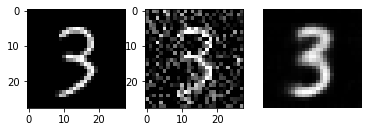

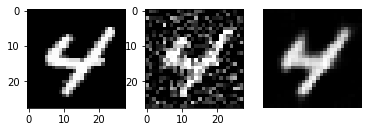

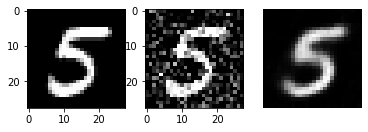

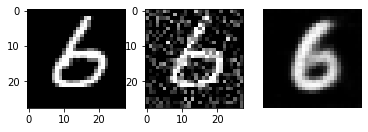

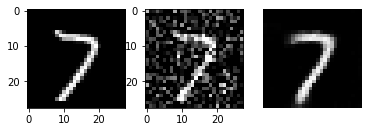

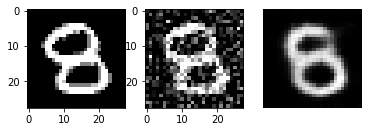

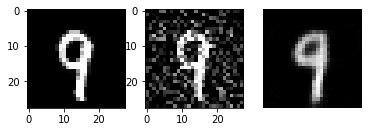

In [10]:
plt.figure(figsize=(28,28))
for i in range(10):
  T = True
  sample = None
  while T:
    n = np.random.randint(0, len(train_data))
    if train_data_noised[n][2]==i:
      sample = train_data_noised[n]
      T = False
  img = sample[0]
  # print(img)
  noised_img = sample[1]
  noised_img = noised_img.to(device)
  res_img = encoder(noised_img.view(1,1,28,28))
  res_img = decoder(res_img).view(28,28)

  plt.subplot(1,3,1)
  plt.imshow(img.view(28,28),cmap="gray")
  plt.subplot(1,3,2)
  plt.imshow(noised_img.view(28,28).detach().cpu().numpy(),cmap="gray")
  plt.subplot(1,3,3)
  plt.imshow(res_img.detach().cpu().numpy(),cmap="gray")
  plt.axis('off')
  plt.show()



###PART 4:

In [11]:
def latent_space(input):
  return encoder(input)

###PART 5:

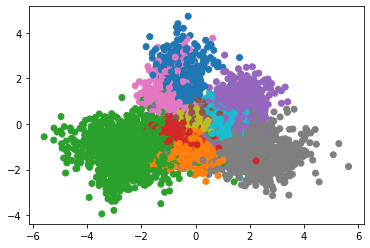

In [12]:
X = None
for id, (images, noised_images, labels) in enumerate(test_loader):
  noised_images = noised_images.to(device)
  labels = labels.to(device).view(len(labels), 1)
  x = torch.cat((latent_space(noised_images), labels), 1)
  X = (x if X == None else torch.cat((X,x),0))


pca = PCA(n_components=2)
Xpca = pca.fit_transform(X[:,0:4].detach().cpu().numpy())
Xpca = torch.cat((torch.tensor(Xpca).to(device), X[:,4].view(-1,1)), 1)

plt.scatter(Xpca[:,0].detach().cpu().numpy() , Xpca[:,1].detach().cpu().numpy() , c = Xpca[:,2].detach().cpu().numpy(), cmap="tab10",)
plt.show()

###PART 6:

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


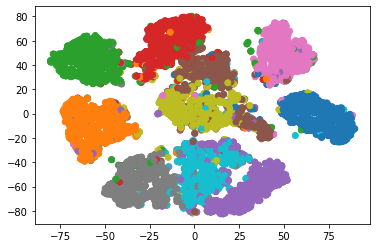

In [13]:
tsne = TSNE(n_components=2)
Xtsne = tsne.fit_transform(X[:,0:4].detach().cpu().numpy())
Xtsne = torch.cat((torch.tensor(Xtsne).to(device), X[:,4].view(-1,1)), 1)
plt.scatter(Xtsne[:,0].detach().cpu().numpy() , Xtsne[:,1].detach().cpu().numpy() , c = Xtsne[:,2].detach().cpu().numpy(), cmap="tab10")
plt.show()

###It will take 1 min and 15 seconds generally to run this block###

###Part 7:

می دانیم که در اتواینکودرها، ما به دنبال این هستیم که نخست ابعاد دیتای ورودی را تا جای ممکن کاهش دهیم به گونه ای که اطلاعات مهم و حیاتی که برای تشخیص آن داده و لیبلش مورد نیاز است در آن ابعاد کاهش یافته شده نیز وجود داشته باشد. و در واقع در بخش اینکودر، این کار انجام شده و بردار لیتنت ساخته می شود. حال با توجه به نتایج تصویری بخش 6 و 7، متوجه می‌شویم که اتواینکودر به طور مناسبی فضای لیتنت را ساخته است، زیرا که می‌توان گفت با تقریب خوبی داده‌های مربوط به هر عدد در یک خوشه قرار گرفته اند و جدا از هم شده اند و این یعنی درایه‌های بردار لیتنت که تعدادشان از بعد داده ورودی نیز کمتر است، توانسته اطلاعات مهم داده و خواصش را در آن به خوبی حفظ کند.

###Part 1 (Bonus):

In [14]:
transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(0,360))
])

train_data_rotated = [[transform3(d[0]) , transform(d[0]), d[1]] for d in train_data]
val_data_rotated = [[transform3(d[0])  , transform(d[0]), d[1]] for d in val_data]
test_data_rotated = [[transform3(d[0])  , transform(d[0]), d[1]] for d in test_MNIST]

train_loader = torch.utils.data.DataLoader(train_data_rotated, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data_rotated, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_rotated, batch_size=batch_size, shuffle=True)